## SEIR Model

Based on http://gabgoh.github.io/COVID/index.html, with modifications

In [14]:
# Importing modules
import numpy
import pandas as pd
from src.seir_expanded import simulator

ModuleNotFoundError: No module named 'src'

In [2]:
# Enables automatic black formatting when executing cells
%load_ext lab_black

In [3]:
def simulator(parameters, start, periods, dT):

    """Modified SEIR model"""

    ## Retrieving parameters

    # List with integers which denote days when r_0 changes, e.g. [25, 55, ...]
    r_0_days = parameters["r_0_days"]
    # List with floats for the r_0 values associated with these changes,
    # e.g. [3.5, 2.5, ...]
    r_0_values = parameters["r_0_values"]

    t_infectious = parameters["t_infectious"]
    t_incubation = parameters["t_incubation"]
    t_recovery_mild = parameters["t_recovery_mild"]
    t_recovery_severe = parameters["t_recovery_severe"]
    t_hospital_lag = parameters["t_hospital_lag"]
    t_death = parameters["t_death"]
    p_severe = parameters["p_severe"]
    p_fatal = parameters["p_fatal"]

    a = 1 / t_incubation
    gamma = 1 / t_infectious

    p_mild = 1 - p_severe - p_fatal

    niter = int(periods / dT)

    series = {
        "T": [start["T"]],
        "S": [start["S"]],
        "E": [start["E"]],
        "I": [start["I"]],
        "I_mild": [start["I_mild"]],
        "I_severe_home": [start["I_severe_home"]],
        "I_severe_hospital": [start["I_severe_hospital"]],
        "I_fatal_home": [start["I_fatal_home"]],
        "I_fatal_hospital": [start["I_fatal_hospital"]],
        "R_from_mild": [start["R_from_mild"]],
        "R_from_severe": [start["R_from_severe"]],
        "Dead": [start["Dead"]],
    }

    # Creation of the r_0 path (a list of length niter / a step function of r_0 values)
    r_0_path = []
    previous_day = 0
    for cc in range(len(r_0_days)):

        r_0_path += (r_0_days[cc] - previous_day) * [r_0_values[cc]]
        previous_day = r_0_days[cc]

    ## Iterations
    for i in range(niter):

        # Computing the current beta
        beta = r_0_path[int(i * dT)] / t_infectious

        ## Current model iteration

        T = series["T"][-1]
        S = series["S"][-1]
        E = series["E"][-1]
        I = series["I"][-1]
        I_mild = series["I_mild"][-1]
        I_severe_home = series["I_severe_home"][-1]
        I_severe_hospital = series["I_severe_hospital"][-1]
        I_fatal_home = series["I_fatal_home"][-1]
        I_fatal_hospital = series["I_fatal_hospital"][-1]
        R_from_mild = series["R_from_mild"][-1]
        R_from_severe = series["R_from_severe"][-1]
        Dead = series["Dead"][-1]

        dS = (-beta * I * S) * dT
        dE = (beta * I * S - a * E) * dT
        dI = (a * E - gamma * I) * dT

        # Flows into three mutually exclusive courses of the illness
        # A: Mild course
        dI_mild = (p_mild * gamma * I - (1 / t_recovery_mild) * I_mild) * dT

        # B: Severe course (two steps)
        dI_severe_home = (
            p_severe * gamma * I - (1 / t_hospital_lag) * I_severe_home
        ) * dT
        dI_severe_hospital = (
            (1 / t_hospital_lag) * I_severe_home
            - (1 / t_recovery_severe) * I_severe_hospital
        ) * dT

        # C: Fatal course (two steps; in this version, fatal cases follow the same
        # route as severe cases: first home, then hospital. This tries to ensure that
        # they show up in the hospital statistics of the model as well)
        dI_fatal_home = (p_fatal * gamma * I - (1 / t_hospital_lag) * I_fatal_home) * dT
        dI_fatal_hospital = (
            (1 / t_hospital_lag) * I_fatal_home - (1 / t_death) * I_fatal_hospital
        ) * dT

        # Final flows from courses of ilness into recovery or death
        dR_from_mild = ((1 / t_recovery_mild) * I_mild) * dT
        dR_from_severe = ((1 / t_recovery_severe) * I_severe_hospital) * dT
        dDead = ((1 / t_death) * I_fatal_hospital) * dT

        ## Storing simulated time series

        series["T"].append(T + dT)
        series["S"].append(S + dS)
        series["E"].append(E + dE)
        series["I"].append(I + dI)
        series["I_mild"].append(I_mild + dI_mild)
        series["I_severe_home"].append(I_severe_home + dI_severe_home)
        series["I_severe_hospital"].append(I_severe_hospital + dI_severe_hospital)
        series["I_fatal_home"].append(I_fatal_home + dI_fatal_home)
        series["I_fatal_hospital"].append(I_fatal_hospital + dI_fatal_hospital)
        series["R_from_mild"].append(R_from_mild + dR_from_mild)
        series["R_from_severe"].append(R_from_severe + dR_from_severe)
        series["Dead"].append(Dead + dDead)

    return series

In [4]:
# Calibration: Alternating regimes of exposure and social distancing (see r_0_values)

# Note:
# - Hospitalisation rate is assumed to be p_severe + p_fatal = 20%
# - We might need to modify the model further to differentiate between hospitalised
# cases (here 20%) and the much smaller subset of ICU cases. A quick hack could be
# to just multiply 'I_severe_hospital' by a conditional ICU fraction we find in the
# literature, to then add all of 'I_fatal_hospital', and to call this time series ICUs

periods = 100
dT = 0.01

parameters = {
    "r_0_days": [21, 42, 63, 100],  # note: the last entry has to equal 'periods'
    "r_0_values": [3.5, 1.25, 2.5, 1.25],
    "t_infectious": 2.9,
    "t_incubation": 5.2,
    "p_severe": 0.18,
    "p_fatal": 0.02,
    "t_recovery_mild": 15 - 2.9,
    "t_recovery_severe": 31.5 - 2.9,
    "t_hospital_lag": 5,
    "t_death": 32 - 2.9,
}

N = 10000
start = {
    "T": 0.0,
    "S": 1.0 - 1 / N,
    "E": 1.0 / N,
    "I": 0.0,
    "I_mild": 0.0,
    "I_severe_home": 0.0,
    "I_severe_hospital": 0.0,
    "I_fatal_home": 0.0,
    "I_fatal_hospital": 0.0,
    "R_from_mild": 0.0,
    "R_from_severe": 0.0,
    "Dead": 0,
}

In [5]:
# Simulation
simulations = simulator(parameters, start, periods, dT)
simulations = pd.DataFrame.from_dict(simulations)
simulations.index = simulations["T"]

In [6]:
simulations["Hospitalised"] = (
    simulations["I_severe_hospital"] + simulations["I_fatal_hospital"]
)

In [7]:
# Plots

,T,S,E,I,I_mild,I_severe_home,I_severe_hospital,I_fatal_home,I_fatal_hospital,R_from_mild,R_from_severe,Dead,Hospitalised
T,,,,,,,,,,,,,
0.00,0.00,0.999900,0.000100,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.01,0.01,0.999900,0.000100,1.923077e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.02,0.02,0.999900,0.000100,3.835824e-07,5.305040e-10,1.193634e-10,0.000000e+00,1.326260e-11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.03,0.03,0.999900,0.000099,5.738330e-07,1.588224e-09,3.572103e-10,2.387268e-13,3.969004e-11,2.652520e-14,4.384330e-13,0.000000e+00,0.000000e+00,2.652520e-13
0.04,0.04,0.999900,0.000099,7.630679e-07,3.169899e-09,7.126681e-10,9.530640e-13,7.918534e-11,1.058962e-13,1.751015e-12,8.347091e-17,9.115189e-18,1.058960e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99.96,99.96,0.413148,0.013998,9.701533e-03,6.833495e-02,4.371091e-03,4.257775e-02,4.856768e-04,4.789665e-03,3.821868e-01,5.441855e-02,5.987702e-03,4.736741e-02
99.97,99.97,0.413131,0.013989,9.694999e-03,6.830523e-02,4.368370e-03,4.257160e-02,4.853745e-04,4.788990e-03,3.822433e-01,5.443344e-02,5.989348e-03,4.736059e-02
99.98,99.98,0.413113,0.013979,9.688469e-03,6.827553e-02,4.365651e-03,4.256545e-02,4.850723e-04,4.788315e-03,3.822997e-01,5.444833e-02,5.990994e-03,4.735377e-02


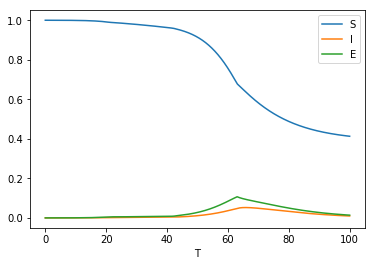

In [11]:
simulations[["S", "I", "E"]].plot()

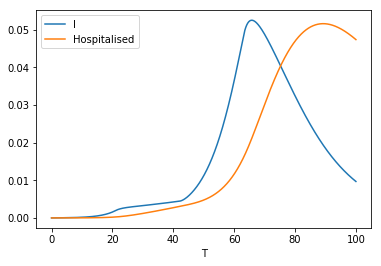

In [9]:
simulations[["I", "Hospitalised"]].plot()

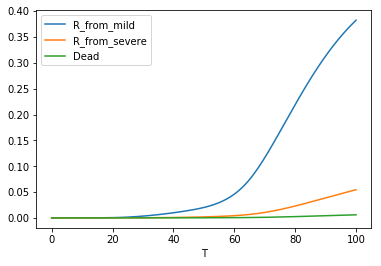

In [10]:
simulations[["R_from_mild", "R_from_severe", "Dead"]].plot()

In [ ]:
# Code snippet of the version from the blog/dashboard (issue: fatalities seem not to
# show up in hospitals)


# Flows into three different subclasses of infectious
# A: Mild course
dI_mild = (
    p_mild * gamma * I - (1 / t_recovery_mild) * I_mild
) * dT

# B: Severe  course (has two steps)
dI_severe_home = (
    p_severe * gamma * I - (1 / t_hospital_lag) * I_severe_home
) * dT
dI_severe_hospital = (
    (1 / t_hospital_lag) * I_severe_home
    - (1 / t_recovery_severe) * I_severe_hospital
) * dT

# C: Fatal course
dI_fatal = (p_fatal * gamma * I - (1 / t_death) * I_fatal) * dT

# Flows into recovery or death
dR_from_mild = ((1 / t_recovery_mild) * I_mild) * dT
dR_from_severe = (
    (1 / t_recovery_severe) * I_severe_hospital
) * dT
dDead = ((1 / t_death) * I_fatal) * dT